## Criar o dataset

O objetivo dessa etapa é construir um dataset próprio que contenha uma amostra aleatória dos reviews. Trabalhar com uma dataset muito grande exige muito esforço e custa muito computacionalmente. É possível trabalhar de forma mais eficiente com um corpus* reduzido, desde que a redução não seja feita de forma arbitrária, precisando ser uma amostra aleatória.

> Um corpus é um conjunto de textos que são usados como base de dados em estudos linguísticos, análises de texto, tradução automática, processamento de linguagem natural e outras áreas relacionadas. O objetivo principal de um corpus é fornecer uma amostra representativa da linguagem para análise e estudo. Ele pode ser usado para identificar padrões linguísticos, examinar mudanças na língua ao longo do tempo, desenvolver algoritmos de processamento de linguagem natural e criar recursos linguísticos, como dicionários, ontologias e etiquetas de partes do discurso.

Serão construídos dois corpus: um menor e balanceado e outro maior e mais aleatório. O primeiro é usado para treinar e testar o modelo para solucionar o problema em questão. Após isso, o segundo corpus é usado para simular novas reviews, porém já classificadas. Ou seja, o modelo irá classificar os reviews do corpus maior usando o modelo treinado usando os dados do corpus menos.

In [4]:
import gzip
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import altair

In [5]:
jsonfilename = '/content/drive/MyDrive/Data Science/Portfólio/Pet_Supplies_5.json.gz'

In [6]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(jsonfilename)

In [7]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,3.0,2,True,"12 2, 2016",A2KN4FJVI2TZSF,0972585419,M.G.,I purchased this cd for my Pocket Parrot. It h...,It's okay,1480636800,NaN,NaN
1,3.0,NaN,True,"10 17, 2016",A3RMA1DD66JDRV,0972585419,Susan P.,"Maybe it's just my Amazon parrot, but she's no...",It might work for a different bird,1476662400,NaN,NaN
2,5.0,2,True,"09 9, 2016",AAANYRIEOIT3R,0972585419,Luggie Lugnut,I bought this to help me teach my blue quaker ...,I bought this to help me teach my blue quaker ...,1473379200,NaN,NaN
3,3.0,NaN,True,"08 31, 2016",A3W44VX0LXAOHU,0972585419,Melissa Partin,Bird showed no interest in it....,Three Stars,1472601600,NaN,NaN
4,2.0,NaN,True,"08 18, 2016",A16ZDBZGKYDRSU,0972585419,Cheryle Bell,Didn't do a thing for my African Grey! He hate...,He hated it and it was very obnoxious,1471478400,NaN,NaN


### Dicionário dos Dados
- reviewerID - ID do avaliador;
- asin - ID do produto;
- reviewerName - Nome do avaliador;
- vote - Nota dada para avaliação;
- style - Detalhes do produto;
- reviewText - Texto do review;
- overall - Nota do produto
- summary - Resumo do review
- unixReviewTime - Hora do Review (unix time)
- reviewTime - Hora do Review (raw)
- image - Imagens postadas pelos usuários após a chegada do produto;

In [8]:
df.shape

(2098325, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2098325 entries, 0 to 2098324
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   vote            object 
 2   verified        bool   
 3   reviewTime      object 
 4   reviewerID      object 
 5   asin            object 
 6   reviewerName    object 
 7   reviewText      object 
 8   summary         object 
 9   unixReviewTime  int64  
 10  style           object 
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 194.1+ MB


In [10]:
df.isnull().sum()

overall                 0
vote              1850700
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName           85
reviewText            649
summary               416
unixReviewTime          0
style              661607
image             2032573
dtype: int64

In [11]:
df = df.dropna(subset='reviewText').reset_index(drop=True)

### Distribuição de Notas

Percebe-se um alto volume de notas 5, representando mais do que 50% das avaliações totais. A nota com menor frequência é a 2.

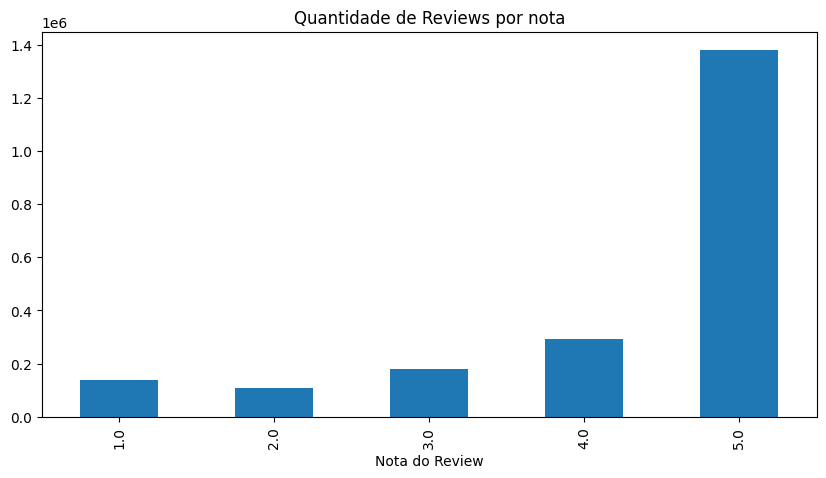

In [12]:
ax = df['overall'].value_counts().sort_index()\
    .plot(kind='bar',
          title= 'Quantidade de Reviews por nota',
          figsize = (10,5))

ax.set_xlabel('Nota do Review')
plt.show()

### Produtos
O dataframe contém 2.098.325 avaliações, distribuídas para 42.531 produtos distintos.

In [13]:
df['asin'].nunique()

42531

### Amostra balanceada de Reviews
Serão separadas amostras de reviews seguindo a distribuição:
- 1500 reviews para avaliações nota 1.
- 500-500-500 para avaliações 2, 3 e 4.
- Para avaliações nota 5, também serão separadas 1500.

Dessa forma teremos um 'corpus' menor, mas balanceado;


In [14]:
df_reviews = df[['overall', 'reviewText']].reset_index(drop=True)
df_reviews.head()

,overall,reviewText
0,3.0,I purchased this cd for my Pocket Parrot. It h...
1,3.0,"Maybe it's just my Amazon parrot, but she's no..."
2,5.0,I bought this to help me teach my blue quaker ...
3,3.0,Bird showed no interest in it....
4,2.0,Didn't do a thing for my African Grey! He hate...


In [15]:
# Extrair índices e classificações
indices = list(range(len(df_reviews['reviewText'])))
ratings = df_reviews['overall']

In [16]:
# Instanciar o RandomUnderSampler
sampler = RandomUnderSampler(sampling_strategy={1.0: 1500, 2.0: 500, 3.0: 500, 4.0: 500, 5.0: 1500}, random_state=42)

# Seleção de amostras balanceadas
indices_sample, ratings_sample = sampler.fit_resample(
    np.array(indices).reshape(-1, 1), np.array(ratings).reshape(-1, 1)
)

In [17]:
# Recuperar os índices e reviews escolhidos no processo de amostragem, separando em dois: os dados da amostra balanceadas e os dados que sobraram.
# As amostras balanceadas não podem fazer parte do conjunto de dados que sobraram.

indices_sample = np.ndarray.flatten(indices_sample)
indices_other = [i for i in list(range(len(df_reviews['reviewText']))) if i not in indices_sample]
reviews_sample = [df_reviews['reviewText'][i] for i in indices_sample]
reviews_other = [df_reviews['reviewText'][i] for i in indices_other]

df_under = pd.DataFrame({"rating": ratings_sample, "review": reviews_sample})

### Amostra aleatória de Reviews
Construindo um 'corpus' maior, com 100 mil reviews, e mais representativo;

In [18]:
# Construindo um dataset mais real com 100 mil amostras aleatórias.
big_sample = np.random.randint(len(reviews_other), size=100000)
reviews_to_be_saved = [(reviews_other[i]) for i in big_sample]
rating_to_be_saved = [df_reviews['overall'][i] for i in big_sample]

df_100k = pd.DataFrame({"rating": rating_to_be_saved, "review": reviews_to_be_saved})

### Construindo Corpora

"Corpora" (plural de "corpus") é um termo usado na linguística e na ciência da computação, especialmente na área de Processamento de Linguagem Natural (PLN). Ele se refere a uma coleção estruturada de textos ou dados linguísticos, geralmente armazenados em formato digital e usados para análise linguística, modelagem de linguagem, treinamento de algoritmos de NLP e muito mais.

In [19]:
df_under.to_csv("/content/small_corpus.csv", index=False)
df_100k.to_csv("/content/big_corpus.csv", index=False)